In [111]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-02-19 06:10:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-19 06:10:54 (53.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [112]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [113]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2025-02-19 06:10:54--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2025-02-19 06:10:54 (117 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [114]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [115]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [116]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [117]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [118]:
len(train_df),len(test_df)

(7613, 3263)

In [119]:
import random
random_index=random.randint(0,len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
    _,text,target=row
    print(f"Target:{target}","(real disaster)" if target>0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target:1 (real disaster)
Text:
when a monster truck racer catches on fire at the fair

---

Target:0 (not real disaster)
Text:
China's Stock Market Crash: Are There Gems In The Rubble?: ChinaÛªs stock market crash this summer h... http://t.co/pE2R3lN16o by .Forbes

---

Target:1 (real disaster)
Text:
GAElite 0    Explosion Greg 2 [Top 3rd] [0 Out] [0 balls] [0 strikes] ... No one on [P: #16 Morgan Orchard] [B: ]

---

Target:0 (not real disaster)
Text:
Is it possible to sneak into a hospital so I can stab myself with a hazardous needle and inject some crazy disease into my veins until I die

---

Target:0 (not real disaster)
Text:
@EBROINTHEAM jay....big L....pun....biggie...wrap over...zero question....fatality...flawless victory http://t.co/Y33QcKq7qD

---



In [120]:
from sklearn.model_selection import train_test_split
train_sent,val_sent,train_label,val_label=train_test_split(train_df_shuffled["text"].to_numpy(),
                                                            train_df_shuffled["target"].to_numpy(),
                                                            test_size=0.1,
                                                            random_state=42)

In [121]:
len(train_sent),len(train_label),len(val_sent),len(val_label)

(6851, 6851, 762, 762)

In [122]:
train_sent[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [123]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [124]:
text_vector=TextVectorization(max_tokens=10000,     #how many words in vocab (replace with <00V>)
                              standardize="lower_and_strip_punctuation",
                              split="whitespace",
                              ngrams=None,
                              output_mode="int",
                              output_sequence_length=None,
                              pad_to_max_tokens=True
                              )

In [125]:
train_sent[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [126]:
round(sum([len(i.split()) for i in train_sent])/len(train_sent))

15

In [127]:
max_vocab_len=10000
max_length=15
text_vectorizer=TextVectorization(max_tokens=max_vocab_len,
                 output_mode='int',
                 output_sequence_length=max_length)

In [128]:
text_vectorizer.adapt(train_sent)

In [129]:
train_sent[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [130]:
sample_sent=train_sent[0]
text_vectorizer([sample_sent]) #tokenization=straight mapping from tkn to no

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 6507,    8,  387,   43, 2956,  978,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [131]:
random_sent=random.choice(train_sent)
print(f"Original text:\n{random_sent}\
      \n\nVectorized version:")
text_vectorizer([random_sent])

Original text:
Noches El-Bestia '@Alexis_Sanchez: happy to see my teammates and training hard ?? goodnight gunners.?????? http://t.co/uc4j4jHvGR'      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,    1,    1,  817,    5,   99,   13, 7758,    7, 1351,  892,
           1,    1,    1,    0]])>

In [132]:
words_in_vocab=text_vectorizer.get_vocabulary()
top5words=words_in_vocab[:5]
bottom5words=words_in_vocab[-5:]
print(len(words_in_vocab),top5words,bottom5words)

10000 ['', '[UNK]', 'the', 'a', 'in'] ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [133]:
train_sent

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

In [134]:
from tensorflow.keras import layers
embedding=layers.Embedding(input_dim=max_vocab_len,
                           output_dim=128, #no div by 8
                           embeddings_initializer="uniform",
                           input_length=max_length)
embedding

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [135]:
random_sent=random.choice(train_sent)
sample_embed=embedding(text_vectorizer([random_sent]))
sample_embed #embedding  =rich repr of relationship btwn tkns
#shape=(1,15,128) 1=1st tweet 15=no of tokens 128=op dim

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02200457,  0.0496969 , -0.00749176, ...,  0.01063191,
         -0.03795727,  0.04668032],
        [-0.03276891, -0.01183058, -0.00113312, ..., -0.03821183,
          0.01033179,  0.00454229],
        [ 0.04960923,  0.01365291, -0.03032383, ..., -0.00353412,
         -0.01228858, -0.0086655 ],
        ...,
        [-0.01667815, -0.0167862 ,  0.01164494, ...,  0.018488  ,
          0.03567472,  0.00429874],
        [ 0.00804197, -0.02891972,  0.00636386, ..., -0.01679271,
          0.01803896,  0.04173611],
        [-0.01118793, -0.01924609, -0.03596858, ..., -0.0045292 ,
         -0.01232375, -0.0226854 ]]], dtype=float32)>

In [136]:
sample_embed[0][0],sample_embed[0][0].shape,random_sent

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.02200457,  0.0496969 , -0.00749176,  0.0006898 ,  0.03956196,
         0.04667219,  0.00487017, -0.03407128, -0.02487451,  0.02253947,
         0.0246504 ,  0.03214106, -0.01910374,  0.03721032,  0.00652178,
         0.0021028 ,  0.04171432,  0.03565663, -0.00654582,  0.03800303,
        -0.03811321, -0.0288605 , -0.01124625, -0.01435032,  0.03210009,
         0.01445857, -0.04074879, -0.0427338 , -0.0446764 , -0.04619722,
         0.03865783,  0.00974268,  0.03574801,  0.04049254, -0.00556562,
         0.03275988, -0.01813012,  0.00393961,  0.04469404, -0.02894471,
         0.01782912, -0.00673022,  0.03440488,  0.03407807,  0.04437399,
        -0.0420195 , -0.01769746,  0.01153727,  0.03307037, -0.04536023,
        -0.01583584,  0.01056085, -0.00107052, -0.00386517, -0.04394562,
        -0.0334235 ,  0.04980801,  0.04237873,  0.01542831,  0.01095863,
         0.01909992,  0.00710883,  0.04539982, -0.00890905, -0.02820085,
  

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

mdl0=Pipeline([
    ("tfidf",TfidfVectorizer()), #convert words to no using tfidf
    ("clf",MultinomialNB())
])
mdl0.fit(train_sent,train_label)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [138]:
bl_score=mdl0.score(val_sent,val_label)

In [139]:
bl_score

0.7926509186351706

In [140]:
bl_pred=mdl0.predict(val_sent)
bl_pred[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [141]:
train_label[:20]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0])

In [142]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def cal_res(ytrue,ypred):
    accuracy=accuracy_score(ytrue,ypred)*100
    precision,recall,f1,_=precision_recall_fscore_support(ytrue,ypred,average="weighted")
    mdl_res={'accuracy':accuracy,
              'precision':precision,
              'recall':recall,
              'f1':f1}
    return mdl_res


In [143]:
bl_res=cal_res(val_label,bl_pred)
bl_res

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [144]:
from helper_functions import create_tensorboard_callback
save_dir='model_logs'

In [145]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)

mdl1=tf.keras.Model(inputs,outputs,name="model_1")

In [146]:
mdl1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_3                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [147]:
mdl1.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [148]:
mdl1_hist=mdl1.fit(x=train_sent,
                   y=train_label,
                   epochs=5,
                   validation_data=(val_sent,val_label),
                   callbacks=[create_tensorboard_callback(dir_name=save_dir,experiment_name='model1')])

Saving TensorBoard log files to: model_logs/model1/20250219-061055
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6541 - loss: 0.6495 - val_accuracy: 0.7638 - val_loss: 0.5357
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8110 - loss: 0.4630 - val_accuracy: 0.7927 - val_loss: 0.4701
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8650 - loss: 0.3499 - val_accuracy: 0.7874 - val_loss: 0.4615
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8842 - loss: 0.2881 - val_accuracy: 0.7927 - val_loss: 0.4659
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9176 - loss: 0.2358 - val_accuracy: 0.7913 - val_loss: 0.4800


In [231]:
m1_pred=mdl1.predict(val_sent)
m1_pred[:20],val_label[:20]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(array([[0.345776  ],
        [0.60267895],
        [0.9805269 ],
        [0.10577524],
        [0.01136385],
        [0.8782904 ],
        [0.54714096],
        [0.9972705 ],
        [0.9876651 ],
        [0.33137265],
        [0.02202006],
        [0.5039498 ],
        [0.05059848],
        [0.34061223],
        [0.00398662],
        [0.18721753],
        [0.02554575],
        [0.03055898],
        [0.22269545],
        [0.7506229 ]], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))

In [150]:

mdl1.evaluate(val_sent,val_label)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7834 - loss: 0.5123


[0.4800071120262146, 0.7913385629653931]

In [151]:
m1_pred.shape

(762, 1)

In [235]:
m1_pred=tf.squeeze(tf.round(m1_pred))
m1_pred[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [153]:
m1_pred[:20],val_label[:20]

(<tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1.], dtype=float32)>,
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))

In [154]:
m1_res=cal_res(val_label,m1_pred)
m1_res

{'accuracy': 79.13385826771653,
 'precision': 0.7957855407433384,
 'recall': 0.7913385826771654,
 'f1': 0.7886149964743017}

In [155]:
bl_res

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [156]:
words_in_vocab=text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [157]:
max_vocab_len

10000

In [158]:
mdl1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_3                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [160]:
emb_weight=mdl1.get_layer('embedding_1').get_weights()[0]
emb_weight.shape

(10000, 128)

In [161]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0:
      continue # skip padding token
  vec = emb_weight[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

In [162]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [163]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype='string')
x=text_vectorizer(inputs)
# print(x.shape)
x=embedding(x)
# print(x.shape)
# x=layers.LSTM(64,return_sequences=True)(x) # that none,15 is retained because ret seq is True
# print(x.shape)
x=layers.LSTM(64)(x)
# print(x.shape)
# x=layers.Dense(64,activation='relu')(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
mdl2=tf.keras.Model(inputs,outputs,name='model_2_LSTM')
mdl2.summary()


Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_3                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [164]:
mdl2.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [165]:
m2_hist=mdl2.fit(x=train_sent,
                   y=train_label,
                   epochs=5,
                   validation_data=(val_sent,val_label),
                   callbacks=[create_tensorboard_callback(dir_name=save_dir,experiment_name='model2')])

Saving TensorBoard log files to: model_logs/model2/20250219-061234
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8876 - loss: 0.3012 - val_accuracy: 0.7822 - val_loss: 0.5434
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9473 - loss: 0.1491 - val_accuracy: 0.7717 - val_loss: 0.6733
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9506 - loss: 0.1275 - val_accuracy: 0.7795 - val_loss: 0.6839
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9594 - loss: 0.1044 - val_accuracy: 0.7743 - val_loss: 0.7691
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9597 - loss: 0.1061 - val_accuracy: 0.7717 - val_loss: 0.9123


In [166]:
m2_pred=mdl2.predict(val_sent)
m2_pred[:20],val_label[:20]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


(array([[3.6573205e-02],
        [6.9936657e-01],
        [9.9974662e-01],
        [5.7981797e-02],
        [9.5945975e-04],
        [9.9932945e-01],
        [8.9155072e-01],
        [9.9986660e-01],
        [9.9975699e-01],
        [2.6327237e-01],
        [2.1140943e-03],
        [9.5457840e-01],
        [6.2699144e-04],
        [9.6298344e-02],
        [2.2783944e-04],
        [3.0457017e-03],
        [1.5725804e-03],
        [1.3349145e-03],
        [1.5432956e-02],
        [9.9909997e-01]], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))

In [167]:
m2_pred=tf.squeeze(tf.round(m2_pred))
m2_pred[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [168]:
m2_res=cal_res(val_label,m2_pred)
m2_res

{'accuracy': 77.16535433070865,
 'precision': 0.773559668677779,
 'recall': 0.7716535433070866,
 'f1': 0.7694523344399301}

In [169]:
bl_res

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [170]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype='string')
x=text_vectorizer(inputs)
x=embedding(x)
#x=layers.GRU(64,return_sequences=True)(x)
# x=layers.LSTM(64,return_sequences=True)(x)
# x=layers.GRU(64)(x)
# x=layers.Dense(64,activation='relu')(x)
x=layers.GRU(64)(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
mdl3=tf.keras.Model(inputs,outputs,name='model_3_GRU')


In [171]:
mdl3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_3                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
mdl3.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [173]:
m3_hist=mdl3.fit(x=train_sent,
                   y=train_label,
                   epochs=5,
                   validation_data=(val_sent,val_label),
                   callbacks=[create_tensorboard_callback(dir_name=save_dir,experiment_name='model3')])

Saving TensorBoard log files to: model_logs/model3/20250219-061247
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8598 - loss: 0.2995 - val_accuracy: 0.7743 - val_loss: 0.7100
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9684 - loss: 0.0899 - val_accuracy: 0.7743 - val_loss: 0.8124
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9743 - loss: 0.0671 - val_accuracy: 0.7769 - val_loss: 0.8894
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9784 - loss: 0.0563 - val_accuracy: 0.7756 - val_loss: 0.9869
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9767 - loss: 0.0578 - val_accuracy: 0.7677 - val_loss: 1.1991


In [174]:
m3_pred=mdl3.predict(val_sent)
m3_pred[:20],val_label[:20]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(array([[2.9457621e-03],
        [7.5048482e-01],
        [9.9961877e-01],
        [1.3229090e-01],
        [2.0980847e-04],
        [9.9965262e-01],
        [9.3985403e-01],
        [9.9988735e-01],
        [9.9976331e-01],
        [9.7544175e-01],
        [9.4478106e-04],
        [9.9491900e-01],
        [4.0756437e-04],
        [5.1865351e-01],
        [1.9686828e-04],
        [2.2177747e-03],
        [1.2439401e-03],
        [3.9647750e-04],
        [2.7491538e-02],
        [9.9963903e-01]], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))

In [175]:
m3_pred=tf.squeeze(tf.round(m3_pred))
m3_pred[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [176]:
m3_res=cal_res(val_label,m3_pred)
m3_res

{'accuracy': 76.77165354330708,
 'precision': 0.7673454393039123,
 'recall': 0.7677165354330708,
 'f1': 0.7671452951501907}

In [177]:
bl_res

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [178]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype='string')
x=text_vectorizer(inputs)
x=embedding(x)
#x=layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
x=layers.Bidirectional(layers.LSTM(64))(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
mdl4=tf.keras.Model(inputs,outputs,name='model_4_Bidirectional')

In [179]:
mdl4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_3                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [180]:
mdl4.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [181]:
m4_hist=mdl4.fit(x=train_sent,
                   y=train_label,
                   epochs=5,
                   validation_data=(val_sent,val_label),
                   callbacks=[create_tensorboard_callback(dir_name=save_dir,experiment_name='model4')])

Saving TensorBoard log files to: model_logs/model4/20250219-061300
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9421 - loss: 0.1978 - val_accuracy: 0.7730 - val_loss: 1.0240
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9760 - loss: 0.0566 - val_accuracy: 0.7730 - val_loss: 1.0200
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9807 - loss: 0.0444 - val_accuracy: 0.7677 - val_loss: 1.2842
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9797 - loss: 0.0438 - val_accuracy: 0.7664 - val_loss: 1.3286
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9808 - loss: 0.0436 - val_accuracy: 0.7717 - val_loss: 1.4134


In [182]:
m4_pred=mdl4.predict(val_sent)
m4_pred[:20],val_label[:20]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


(array([[1.1745313e-03],
        [7.2657049e-01],
        [9.9998426e-01],
        [1.3160209e-02],
        [2.9030127e-05],
        [9.9991143e-01],
        [9.6531790e-01],
        [9.9999201e-01],
        [9.9998391e-01],
        [9.9216473e-01],
        [6.2165098e-05],
        [9.7398639e-01],
        [7.8632540e-05],
        [1.2802148e-01],
        [2.9774958e-05],
        [6.6924363e-04],
        [3.7595873e-05],
        [3.9397437e-05],
        [5.5310377e-03],
        [9.9980229e-01]], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))

In [183]:
m4_pred=tf.squeeze(tf.round(m4_pred))
m4_pred[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [184]:
m4_res=cal_res(val_label,m4_pred)
m4_res

{'accuracy': 77.16535433070865,
 'precision': 0.7732961359962456,
 'recall': 0.7716535433070866,
 'f1': 0.7695827090439606}

In [185]:
emb_test=embedding(text_vectorizer(["this is a test sentence"]))
emb_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00978084, -0.05110572,  0.0142106 , ...,  0.04244933,
         -0.00760303, -0.0692753 ],
        [-0.01921474, -0.01171204, -0.06244833, ..., -0.05412738,
         -0.05089587, -0.00521989],
        [ 0.00896143, -0.04018319,  0.02266031, ...,  0.01618149,
         -0.06812675,  0.00943389],
        ...,
        [ 0.00039535, -0.02006581,  0.01257801, ..., -0.04415107,
         -0.0396241 , -0.04073502],
        [ 0.00039535, -0.02006581,  0.01257801, ..., -0.04415107,
         -0.0396241 , -0.04073502],
        [ 0.00039535, -0.02006581,  0.01257801, ..., -0.04415107,
         -0.0396241 , -0.04073502]]], dtype=float32)>

In [186]:
conv_1D=layers.Conv1D(filters=64,kernel_size=5,strides=1,padding='valid',activation='relu')
conv_1D_out=conv_1D(emb_test)
max_pool=layers.GlobalMaxPool1D()
max_pool_out=max_pool(conv_1D_out)
max_pool_out
emb_test.shape,conv_1D_out.shape,max_pool_out.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 64]), TensorShape([1, 64]))

In [187]:
emb_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00978084, -0.05110572,  0.0142106 , ...,  0.04244933,
         -0.00760303, -0.0692753 ],
        [-0.01921474, -0.01171204, -0.06244833, ..., -0.05412738,
         -0.05089587, -0.00521989],
        [ 0.00896143, -0.04018319,  0.02266031, ...,  0.01618149,
         -0.06812675,  0.00943389],
        ...,
        [ 0.00039535, -0.02006581,  0.01257801, ..., -0.04415107,
         -0.0396241 , -0.04073502],
        [ 0.00039535, -0.02006581,  0.01257801, ..., -0.04415107,
         -0.0396241 , -0.04073502],
        [ 0.00039535, -0.02006581,  0.01257801, ..., -0.04415107,
         -0.0396241 , -0.04073502]]], dtype=float32)>

In [188]:
conv_1D_out

<tf.Tensor: shape=(1, 11, 64), dtype=float32, numpy=
array([[[0.01962932, 0.        , 0.        , 0.        , 0.04160323,
         0.        , 0.01046608, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.04039557,
         0.01253882, 0.        , 0.        , 0.        , 0.02696462,
         0.        , 0.03178727, 0.        , 0.03291669, 0.        ,
         0.04441265, 0.03470465, 0.        , 0.        , 0.00900897,
         0.00711958, 0.        , 0.03716158, 0.08020133, 0.        ,
         0.06024731, 0.        , 0.00421029, 0.02417937, 0.050746  ,
         0.        , 0.03454344, 0.        , 0.02029767, 0.        ,
         0.        , 0.        , 0.01862122, 0.00153512, 0.03169572,
         0.00050004, 0.        , 0.06016089, 0.01067114, 0.01131435,
         0.        , 0.        , 0.        , 0.        , 0.01498282,
         0.04457741, 0.02013456, 0.        , 0.        ],
        [0.02008379, 0.03927389, 0.0103426 , 0.00535737, 0.05

In [189]:
max_pool_out

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.06820288, 0.03927389, 0.0705763 , 0.00535737, 0.0575015 ,
        0.04151021, 0.0180105 , 0.06534372, 0.00937789, 0.04513021,
        0.        , 0.        , 0.03209027, 0.        , 0.04439979,
        0.01253882, 0.        , 0.        , 0.06388301, 0.04973615,
        0.01369801, 0.10495061, 0.05187305, 0.05638859, 0.03274948,
        0.04441265, 0.03614999, 0.03988653, 0.05555977, 0.05958679,
        0.02258379, 0.02120261, 0.03994309, 0.08020133, 0.06822843,
        0.09823636, 0.        , 0.00836359, 0.02417937, 0.050746  ,
        0.02353796, 0.03454344, 0.        , 0.02029767, 0.03733345,
        0.        , 0.        , 0.02953758, 0.00611139, 0.03169572,
        0.04218592, 0.04526355, 0.09827466, 0.06803468, 0.0687943 ,
        0.0833933 , 0.01792609, 0.04979246, 0.03125574, 0.06553105,
        0.05456448, 0.04865392, 0.01081391, 0.        ]], dtype=float32)>

In [190]:
from tensorflow.keras import layers
input=layers.Input(shape=(1,),dtype='string')
x=text_vectorizer(input)
x=embedding(x)
x=layers.Conv1D(filters=64,kernel_size=5,strides=1,activation='relu')(x)
x=layers.GlobalMaxPool1D()(x)
output=layers.Dense(1,activation='sigmoid')(x)
mdl5=tf.keras.Model(input,output,name='model_5_Conv1D')

mdl5.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

m5_hist=mdl5.fit(x=train_sent,
                   y=train_label,
                   epochs=5,
                   validation_data=(val_sent,val_label),
                   callbacks=[create_tensorboard_callback(dir_name=save_dir,experiment_name='model5')])

Saving TensorBoard log files to: model_logs/model5/20250219-061319
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9397 - loss: 0.1734 - val_accuracy: 0.7743 - val_loss: 0.9044
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9764 - loss: 0.0679 - val_accuracy: 0.7664 - val_loss: 1.0350
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9800 - loss: 0.0571 - val_accuracy: 0.7717 - val_loss: 1.1438
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9795 - loss: 0.0512 - val_accuracy: 0.7625 - val_loss: 1.2276
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9827 - loss: 0.0409 - val_accuracy: 0.7520 - val_loss: 1.1984


In [191]:
m5_pred=mdl5.predict(val_sent)
m5_pred[:20],val_label[:20]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(array([[4.7734582e-01],
        [9.2636609e-01],
        [9.9993682e-01],
        [5.9576388e-02],
        [2.4356484e-07],
        [9.9980325e-01],
        [9.9659818e-01],
        [9.9997902e-01],
        [9.9999964e-01],
        [9.4665039e-01],
        [1.6771671e-07],
        [9.3761152e-01],
        [1.2422062e-04],
        [1.7801762e-01],
        [1.4064270e-06],
        [8.0325035e-03],
        [2.0560867e-03],
        [3.9735703e-05],
        [1.8296228e-01],
        [9.9878567e-01]], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))

In [192]:
m5_pred=tf.squeeze(tf.round(m5_pred))
m5_pred[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [193]:
m5_res=cal_res(val_label,m5_pred)
m5_res

{'accuracy': 75.19685039370079,
 'precision': 0.7515971160731627,
 'recall': 0.7519685039370079,
 'f1': 0.7516773461494521}

In [194]:
import tensorflow_hub as hub
embed=hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples=embed([sample_sent,'when u use the universal encoder on sent it turns it into no'])
embed_samples[0][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.00637726,  0.06420986, -0.04316848, -0.00235369,  0.02946224,
       -0.02190254, -0.01300303,  0.00449698,  0.02886852,  0.05868739,
        0.02420558,  0.03282705, -0.0640588 , -0.06798837, -0.04915178,
       -0.02951979,  0.06283469, -0.05168452,  0.04366941,  0.01036603,
       -0.03923148, -0.02772979, -0.05414097, -0.01161895, -0.08427423,
       -0.00425597, -0.00071072, -0.06232065, -0.06833261, -0.0268549 ,
       -0.04910006,  0.01437167,  0.00183259,  0.02524296, -0.03412737,
       -0.07461061, -0.04162933,  0.03238095,  0.01570485, -0.038799  ,
        0.05871558,  0.02097506, -0.03287273, -0.07144441, -0.02175844,
        0.03108379, -0.03148854, -0.00777571,  0.01874437,  0.00196516],
      dtype=float32)>

In [195]:
sample_sent,embed_samples

('@mogacola @zamtriossu i screamed after hitting tweet',
 <tf.Tensor: shape=(2, 512), dtype=float32, numpy=
 array([[-0.00637726,  0.06420986, -0.04316848, ..., -0.00951677,
          0.00851021, -0.01419207],
        [-0.00453196, -0.0253504 , -0.01013521, ..., -0.04948081,
          0.06041053, -0.05026159]], dtype=float32)>)

In [196]:
sent_encoder_larer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                input_shape=[],
                                dtype=tf.string,
                                trainable=False,
                                name='USE')

In [197]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Load Universal Sentence Encoder
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,  # Keep it non-trainable
    name="USE"
)

# Functional API Model Definition
input_text = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")

# Directly apply the USE layer without Lambda
embedding = use_layer(input_text)

# Define the rest of the model
dense1 = layers.Dense(64, activation='relu')(embedding)
output = layers.Dense(1, activation='sigmoid')(dense1)

mdl6 = tf.keras.Model(inputs=input_text, outputs=output, name="model_6_USE")

# Print Model Summary
mdl6.summary()


TypeError: Exception encountered when calling layer 'USE' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None,), dtype=string, sparse=False, name=input_text>,) and kwargs: {} for signature: (inputs: TensorSpec(shape=<unknown>, dtype=tf.string, name=None)).

Call arguments received by layer 'USE' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=string, sparse=False, name=input_text>
  • training=None

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)  # Ensure it's at least 2.4+
print(hub.__version__)

In [ ]:
mdl6.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])
mdl6.summary()

In [ ]:
m6_hist=mdl6.fit(train_sent,
                 train_label,
                 epochs=5,
                 validation_data=(val_sent,val_label),
                 callbacks=[create_tensorboard_callback(dir_name=save_dir,experiment_name='model6')])

In [ ]:
m6_pred=mdl6.predict(val_sent)
m6_pred[:20],val_label[:20]

In [ ]:
m6_res=cal_res(val_label,tf.squeeze(tf.round(m6_pred)))
m6_res

In [198]:
all_model_res=pd.DataFrame({'model':['baseline','model1:Simple Dense','model2:LSTM','model3:GRU','model4:bidirectional','model5:conv1D'],
                            'accuracy':[bl_res['accuracy'],m1_res['accuracy'],m2_res['accuracy'],m3_res['accuracy'],m4_res['accuracy'],m5_res['accuracy']],
                            'precision':[bl_res['precision'],m1_res['precision'],m2_res['precision'],m3_res['precision'],m4_res['precision'],m5_res['precision']],
                            'recall':[bl_res['recall'],m1_res['recall'],m2_res['recall'],m3_res['recall'],m4_res['recall'],m5_res['recall']],
                            'f1':[bl_res['f1'],m1_res['f1'],m2_res['f1'],m3_res['f1'],m4_res['f1'],m5_res['f1']]})

In [199]:
all_model_res

,model,accuracy,precision,recall,f1
0,baseline,79.265092,0.811139,0.792651,0.786219
1,model1:Simple Dense,79.133858,0.795786,0.791339,0.788615
2,model2:LSTM,77.165354,0.773560,0.771654,0.769452
3,model3:GRU,76.771654,0.767345,0.767717,0.767145
4,model4:bidirectional,77.165354,0.773296,0.771654,0.769583
5,model5:conv1D,75.196850,0.751597,0.751969,0.751677


In [200]:

all_model_res['precision']=all_model_res['precision']*100
all_model_res['recall']=all_model_res['recall']*100
all_model_res['f1']=all_model_res['f1']*100

In [201]:
all_model_res

,model,accuracy,precision,recall,f1
0,baseline,79.265092,81.113900,79.265092,78.621898
1,model1:Simple Dense,79.133858,79.578554,79.133858,78.861500
2,model2:LSTM,77.165354,77.355967,77.165354,76.945233
3,model3:GRU,76.771654,76.734544,76.771654,76.714530
4,model4:bidirectional,77.165354,77.329614,77.165354,76.958271
5,model5:conv1D,75.196850,75.159712,75.196850,75.167735


<Axes: xlabel='model'>

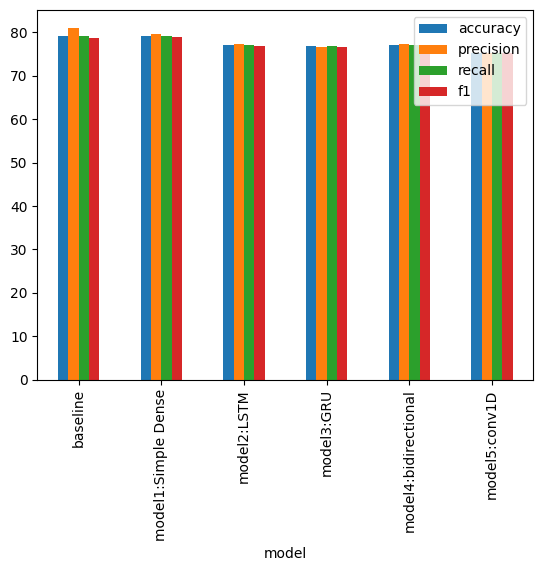

In [202]:
all_model_res.plot(x='model',y=['accuracy','precision','recall','f1'],kind='bar')

<Axes: >

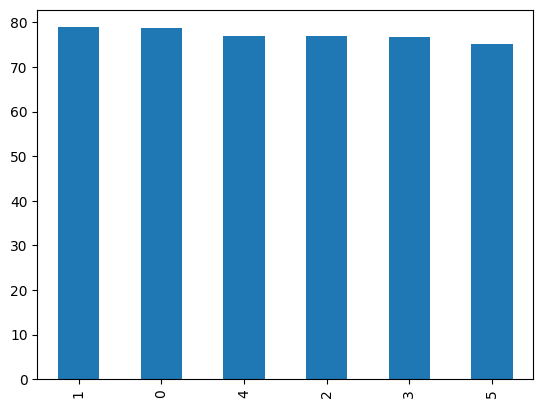

In [203]:
all_model_res.sort_values('f1',ascending=False)['f1'].plot(kind='bar')

In [204]:
!tensorboard dev upload --logdir ./model_logs/ \
 --name 'NLP modelling exp ZTM COURSE' \
 --description 'comparing diff models of NLP' \
 --one_shot

2025-02-19 06:22:02.148009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739946122.169017   11095 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739946122.175347   11095 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [206]:
mdl1.save('model_1.h5')

In [210]:
import tensorflow_hub as hub
loaded_mdl1=tf.keras.models.load_model('model_1.h5',
                                custom_objects={'KerasLayer':hub.KerasLayer})

In [214]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Load the model
loaded_mdl1 = tf.keras.models.load_model("model_1.h5", compile=False)

# If TextVectorization exists in your model, reinitialize the vocabulary
vectorizer_layer = loaded_mdl1.get_layer("text_vectorization_3")  # Adjust layer name if needed
vectorizer_layer.adapt(train_sent)  # Re-adapt using training data

# Compile model
loaded_mdl1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Evaluate again
loaded_mdl1.evaluate(val_sent, val_label)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7406 - loss: 0.5915


[0.5490036010742188, 0.7624672055244446]

In [212]:
mdl1.evaluate(val_sent,val_label)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7406 - loss: 0.5915


[0.5490036010742188, 0.7624672055244446]

In [239]:
val_df=pd.DataFrame({
    'text':val_sent,
    'label':val_label,
    'pred_prob':tf.squeeze(mdl1.predict(val_sent)),
    'pred':(tf.squeeze(m1_pred))
})

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [240]:
val_sent.shape,val_label.shape,tf.squeeze(m1_pred).shape,mdl1.predict(val_sent).shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


((762,), (762,), TensorShape([762]), (762, 1))

In [241]:
  val_df

,text,label,pred_prob,pred
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.345776,0.0
1,FedEx no longer to transport bioterror germs i...,0,0.602679,1.0
2,Gunmen kill four in El Salvador bus attack: Su...,1,0.980527,1.0
3,@camilacabello97 Internally and externally scr...,1,0.105775,0.0
4,Radiation emergency #preparedness starts with ...,1,0.011364,0.0
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.076308,0.0
758,@SetZorah dad why dont you claim me that mean ...,0,0.271987,0.0
759,FedEx will no longer transport bioterror patho...,0,0.566095,1.0
760,Crack in the path where I wiped out this morni...,0,0.167540,0.0


In [245]:
most_wrong=val_df[val_df['label']!=val_df['pred']].sort_values('pred_prob',ascending=False)

In [247]:
most_wrong.head()

,text,label,pred_prob,pred
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,0.990444,1.0
303,Trafford Centre film fans angry after Odeon ci...,0,0.972823,1.0
682,A change in the State fire code prohibits gril...,0,0.941393,1.0
206,Head on head collision Ima problem and nobody ...,0,0.887595,1.0
712,WPRI 12 Eyewitness News Rhode Island set to mo...,0,0.874918,1.0


In [248]:
most_wrong.tail()

,text,label,pred_prob,pred
59,You can never escape me. Bullets don't harm me...,1,0.006080,0.0
745,#ClimateChange Eyewitness to Extreme Weather: ...,1,0.003507,0.0
627,Owner of Chicago-Area Gay Bar Admits to Arson ...,1,0.001499,0.0
262,Just came back from camping and returned with ...,1,0.001251,0.0
274,Crazy Mom Threw Teen Daughter a NUDE Twister S...,1,0.001247,0.0


In [251]:
for row in most_wrong[:10].itertuples():
  _,txt,target,pred_prob,pred=row
  print(target,pred,pred_prob,':\n',txt,'\n')
  print('---------------')

0 1.0 0.9904438853263855 :
 åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Tent Collapse Story: Correction: Tent Collapse story åÈ http://t.co/fDJUYvZMrv @wizkidayo 

---------------
0 1.0 0.972823441028595 :
 Trafford Centre film fans angry after Odeon cinema evacuated following false fire alarm   http://t.co/6GLDwx71DA 

---------------
0 1.0 0.9413930773735046 :
 A change in the State fire code prohibits grills on decks at condos and apartment buildings.  Check with your... http://t.co/KE1ZS6NAml 

---------------
0 1.0 0.887594997882843 :
 Head on head collision Ima problem and nobody can solve em on Long division 

---------------
0 1.0 0.8749179840087891 :
 WPRI 12 Eyewitness News Rhode Island set to modernize its voting equipment WPRI 12 EyewitnessÛ_ http://t.co/aP9JBrPmQg 

---------------
0 1.0 0.8733447194099426 :
 Article by Michael Jackman at Metro Times Detroit:
The group later downgraded the estimate to 37 square miles of... http://t.co/h31mmuduqt 

---------------
0 1.0 0.8

In [252]:
for row in most_wrong[:-10].itertuples():
  _,txt,target,pred_prob,pred=row
  print(target,pred,pred_prob,':\n',txt,'\n')
  print('---------------')

0 1.0 0.9904438853263855 :
 åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Tent Collapse Story: Correction: Tent Collapse story åÈ http://t.co/fDJUYvZMrv @wizkidayo 

---------------
0 1.0 0.972823441028595 :
 Trafford Centre film fans angry after Odeon cinema evacuated following false fire alarm   http://t.co/6GLDwx71DA 

---------------
0 1.0 0.9413930773735046 :
 A change in the State fire code prohibits grills on decks at condos and apartment buildings.  Check with your... http://t.co/KE1ZS6NAml 

---------------
0 1.0 0.887594997882843 :
 Head on head collision Ima problem and nobody can solve em on Long division 

---------------
0 1.0 0.8749179840087891 :
 WPRI 12 Eyewitness News Rhode Island set to modernize its voting equipment WPRI 12 EyewitnessÛ_ http://t.co/aP9JBrPmQg 

---------------
0 1.0 0.8733447194099426 :
 Article by Michael Jackman at Metro Times Detroit:
The group later downgraded the estimate to 37 square miles of... http://t.co/h31mmuduqt 

---------------
0 1.0 0.8

In [253]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [263]:
test_sent=test_df['text'].to_list()
test_sent[2]

'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'

In [266]:
import tensorflow as tf
import numpy as np
import random

test_sample = random.sample(test_sent, 10)

for ts in test_sample:
    ts_tensor = tf.convert_to_tensor([ts], dtype=tf.string)  # Ensure it's correctly formatted
    pred_prob = tf.squeeze(mdl1.predict(ts_tensor))  # Ensure output is squeezed properly
    pred = tf.round(pred_prob)

    print(f"Prediction: {int(pred)}, Probability: {pred_prob.numpy():.4f}")
    print(f"Text: {ts}\n")
    print('---------------')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: 0, Probability: 0.1077
Text: Double ebony attack http://t.co/33V0RLlrKf #Black-haired #Blowjob http://t.co/t7TG3nRBje

---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: 1, Probability: 0.8870
Text: It doesn't get any closer. Heavy rain just barely missed @TontitownGrape festival but lightning TOO CLOSE #TGF2015 http://t.co/d9PQIXaTX6

---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction: 0, Probability: 0.0057
Text: SOMEBODY TELL ME HOW TO MEET PIERCE THE VEIL OR SLEEPING WITH SIRENS PLEASE I BEG YOU

---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction: 0, Probability: 0.0456
Text: @mlp_Delrim Please tell my why they might be in danger if they knew what you knew?

---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: 0, Probability: 0.1287
Text: YE SBUJDJSJS YES YES I XUSKAK I SCREAMED PROTECT MY OTHER SON PROTECT UR BOYFRIEND YES  https://t.co/kDqtqGK5pI

---------------
1/1 ━━━━━━━━

In [267]:
bl_res,m1_res

({'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1': 0.7862189758049549},
 {'accuracy': 79.13385826771653,
  'precision': 0.7957855407433384,
  'recall': 0.7913385826771654,
  'f1': 0.7886149964743017})

In [268]:
import time
def pred_timer(mdl,samp):
  start_time=time.perf_counter()
  pred=mdl.predict(samp)
  end_time=time.perf_counter()
  pred_time=end_time-start_time
  time_per_pred=pred_time/len(samp)
  return pred_time,time_per_pred

In [269]:
m1_pred_time,m1_time_per_pred=pred_timer(mdl1,val_sent)
m1_pred_time,m1_time_per_pred

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(0.19725559699963924, 0.00025886561286041893)

In [270]:
bl_pred_time,bl_time_per_pred=pred_timer(mdl0,val_sent)
bl_pred_time,bl_time_per_pred

(0.015938980999635532, 2.0917297899784162e-05)

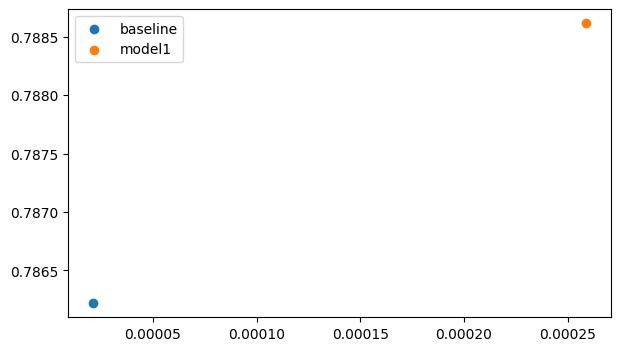

In [272]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.scatter(bl_time_per_pred,bl_res['f1'],label='baseline')
plt.scatter(m1_time_per_pred,m1_res['f1'],label='model1')
plt.legend()